In [42]:
""" External Imports """
import maboss
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import sys
import yaml
import numpy as np
import re
import seaborn as sns
sys.path.append("/Users/emilieyu/endotehelial-masboss")

In [43]:
""" Global Setting Configuration """

PROJECT_ROOT = Path("/Users/emilieyu/endotehelial-masboss/")
CONFIG_PATH = PROJECT_ROOT / "config" / "rho_sim_config.yaml"
SWEEP_CONFIG_PATH = PROJECT_ROOT / "config" / "parameter_sweep_config.yaml"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

with open(SWEEP_CONFIG_PATH, "r") as f:
    sweep_config = yaml.safe_load(f)

# Result directory
RESULTS_DIR = PROJECT_ROOT / config['paths']['results_base']
RESULTS_FINAL_DIR = PROJECT_ROOT / config['paths']['results_base'] / 'final'

# Subdirectories to store parameter sweep / perturbation result
PARAM_DIR = RESULTS_FINAL_DIR / config['paths']['subdirs']['param_sweep']
PERBS_DIR = RESULTS_FINAL_DIR / config['paths']['subdirs']['perturbation_sim']
PERBS_FIG_DIR = RESULTS_DIR / config['paths']['subdirs']['figures_perbs']


In [56]:
perb_csv = PERBS_DIR / 'perturbation_timeseries.csv'
perb_raw = pd.read_csv(perb_csv)


## Perturbation Processing

In [ ]:
def plot_activation_single(perb, df, ax, set_ylim=True):
    """
    Plot RhoA/RhoC activation levels / probabilities for a single perturbation. 
    """
    ax.plot(df['t'], df['RhoA'], label=f"{perb} RhoA")
    ax.plot(df['t'], df['RhoC'], label=f"{perb} RhoC")

    if set_ylim:
        ax.set_ylim(0, 1)

    ax.set_xlabel('Time')
    ax.set_ylabel('Activation Level (Probability)')

    plt.tight_layout()


def plot_activation_prob(name, perb_list, data_dict, outdir=None, set_ylim=True, save=True):
    fig, ax = plt.subplots(figsize=(6,4))

    for perb in perb_list:
        plot_activation_single(perb, data_dict[perb], ax=ax, set_ylim=set_ylim)

    ax.set_title(f"{name}: RhoA/RhoC Activation Over Time")
    ax.legend()
    plt.tight_layout()

    if save and outdir is not None:
        file_name = name.replace(" ", "_")
        fig.savefig(outdir / f"{file_name}_rho_acivation_time.png", dpi=300)

    plt.show()
    plt.close(fig)

def plot_delta_single(perb, df, ax):
    """
    Plot Δ(t) for a single perturbation onto an existing axis.
    """

    ax.plot(df['t'], df["delta"], label=perb)

    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel("Time")
    ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")


def plot_deltas(name, perb_list, data_dict, outdir=None, save=True):
    """
    Plot one or multiple perturbations' Δ(t) on the same axes.
    """
    fig, ax = plt.subplots(figsize=(6,4))

    # Plot each perturbation
    for perb in perb_list:
        plot_delta_single(perb, data_dict[perb], ax)

    # Add reference lines ONCE
    ax.axhline(0.25, linestyle="--", color='mistyrose')
    ax.axhline(-0.25, linestyle="--", color='mistyrose')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_title(f"{name}: Rho Balance Over Time (Δ)")
    ax.legend(title='Perturbation')
    plt.tight_layout()

    if save and outdir is not None:
        file_name = name.replace(" ", "_")
        outpath = outdir / f"{file_name}_delta_time.png"
        fig.savefig(outpath, dpi=300)

    plt.show()

    plt.close()


array(['WT', 'DSP', 'TJP1', 'JCAD', 'DSP_JCAD', 'TJP1_JCAD'], dtype=object)

In [46]:
perb_dfs = {}
for perb, df in perb_raw.groupby('perturbation'):
    perb_dfs[perb] = df

    #plot_activation_prob(perb, [perb], perb_dfs, PERBS_FIG_DIR)
    #plot_deltas(perb, df)


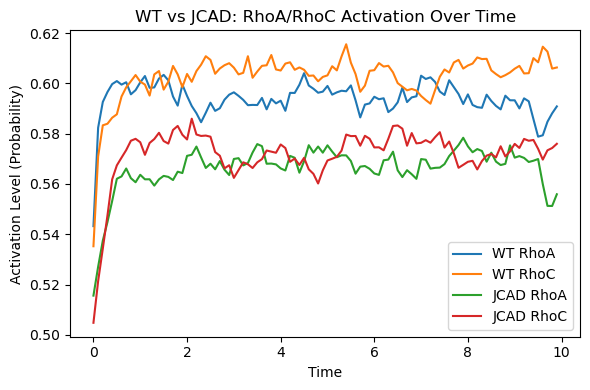

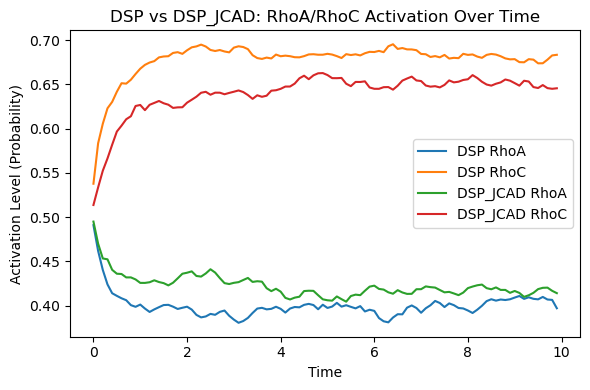

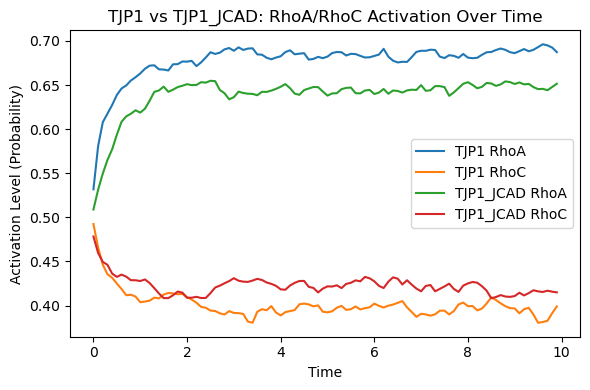

In [33]:
plot_activation_prob('WT vs JCAD', ['WT', 'JCAD'], perb_dfs, PERBS_FIG_DIR, set_ylim=False)
plot_activation_prob('DSP vs DSP_JCAD', ['DSP', 'DSP_JCAD'], perb_dfs, PERBS_FIG_DIR, set_ylim=False)
plot_activation_prob('TJP1 vs TJP1_JCAD', ['TJP1', 'TJP1_JCAD'], perb_dfs, PERBS_FIG_DIR, set_ylim=False)

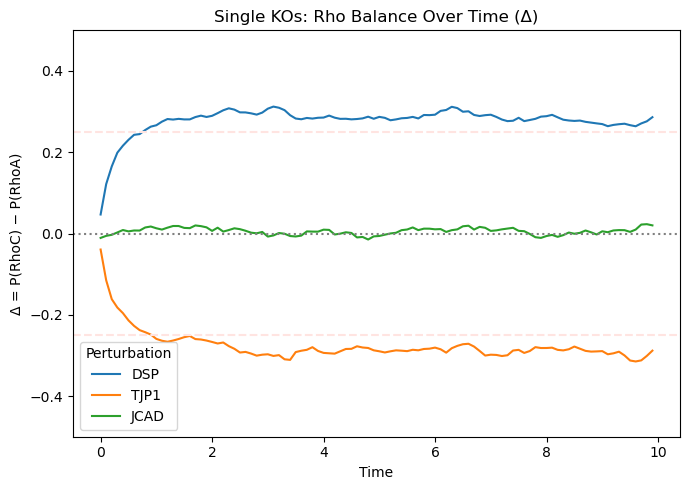

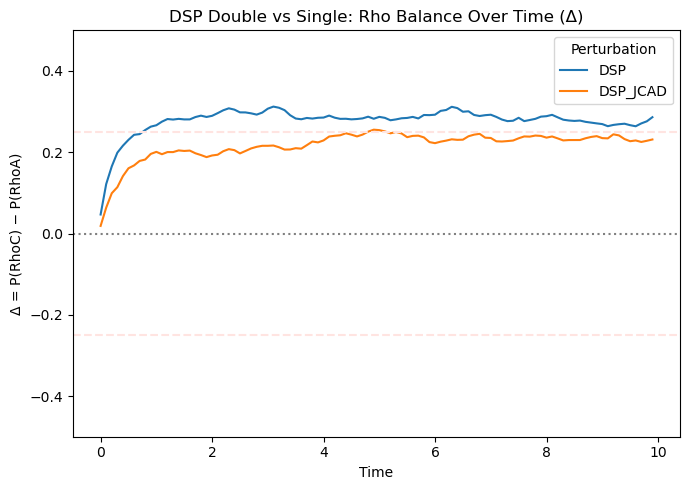

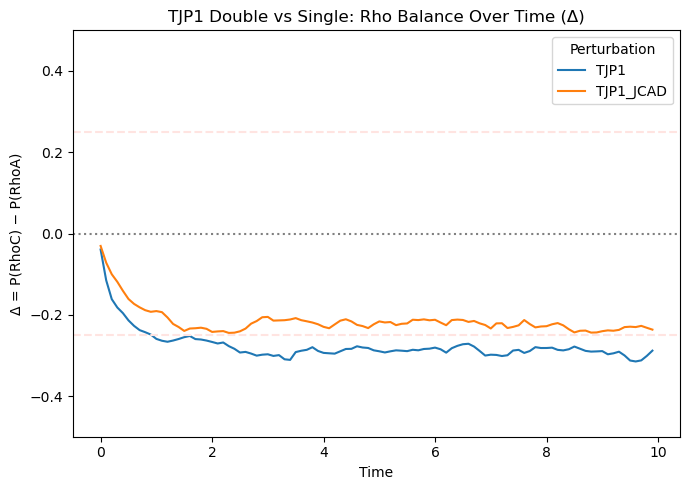

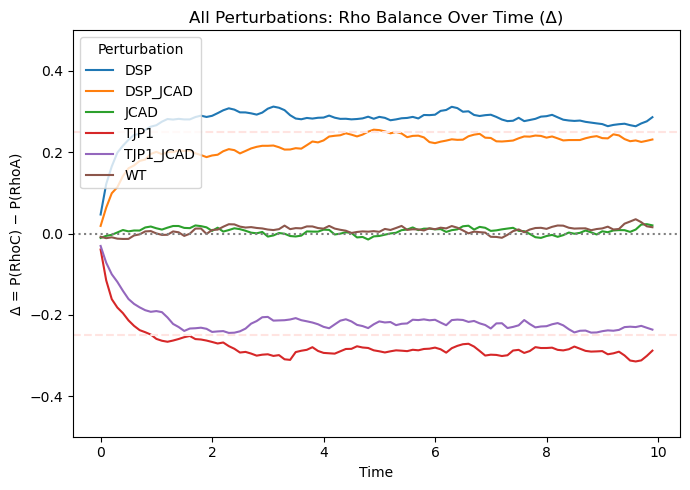

In [55]:
plot_deltas('Single KOs', ['DSP', 'TJP1', 'JCAD'], perb_dfs, PERBS_FIG_DIR)
plot_deltas('DSP Double vs Single', ['DSP', 'DSP_JCAD'], perb_dfs, PERBS_FIG_DIR)
plot_deltas('TJP1 Double vs Single', ['TJP1', 'TJP1_JCAD'], perb_dfs, PERBS_FIG_DIR)
plot_deltas('All Perturbations', perb_dfs.keys(), perb_dfs, PERBS_FIG_DIR)

## Perturbation Steady State Plots

In [116]:
def plot_ss_bar(df, outdir=None, save=True):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(df['perturbation'], df['delta'])

    ax.axhline(0.25, linestyle="--", color='red')
    ax.axhline(-0.25, linestyle="--", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylabel("Steady-State Δ")
    ax.set_ylabel("Perturbation")
    ax.set_title("Steady-State Rho Balances")

    plt.tight_layout()
    plt.show()

    if save and outdir is not None:
        outpath = outdir / "ss_balance_bar.png"
        fig.savefig(outpath, dpi=300)

    plt.show()

    plt.close(fig)


def save_df_as_png(df, filename, outdir = None, save=True, dpi=300):
    """
    Save a pandas DataFrame as a PNG image.
    """

    # Scale figure size based on dataframe shape
    nrows, ncols = df.shape

    fig, ax = plt.subplots(figsize=(ncols * 1.2, nrows * 0.4))
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        cellLoc='left',
        colLabels=df.columns.str.capitalize(),
        colColours=['lightblue']*ncols,
        loc='center'
    )


    table.auto_set_column_width(col=list(range(ncols)))
    table.scale(1, 1.2)

    # Bold header row
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')

    plt.tight_layout()
    if save and outdir is not None:
        outpath = outdir / "ss_table.png"
        fig.savefig(outpath, dpi=300)

    plt.show()
    plt.close(fig)

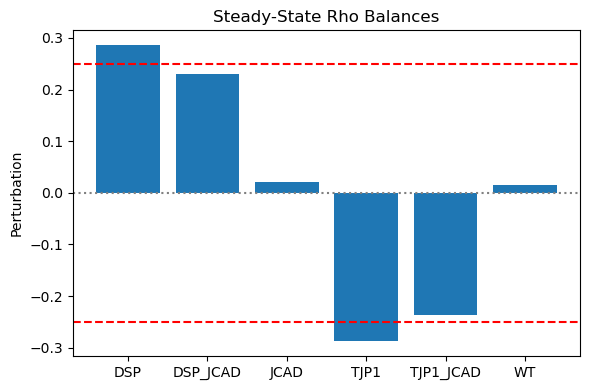

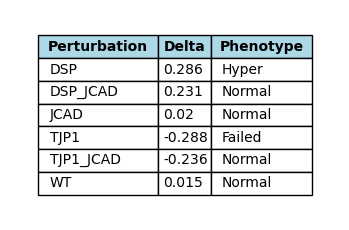

In [122]:
ss_df = perb_raw.loc[perb_raw.groupby('perturbation')['t'].idxmax()].reset_index(drop=True)
ss_df
ss_processed = ss_df[['perturbation', 'delta', 'phenotype']].round(3)
plot_ss_bar(ss_processed, PERBS_FIG_DIR)
save_df_as_png(ss_processed, "ss_table", PERBS_FIG_DIR)

In [121]:
n_rows, n_cols = ss_processed.shape
list(range(n_cols))

[0, 1, 2]

In [15]:
sweep_dfs = {}
for file in PARAM_DIR.iterdir():
    df = pd.read_csv(file)
    clean_name = re.sub(
        r"_\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}",
        "",
        file.stem
    )
    sweep_dfs[clean_name] = df

array(['WT', 'DSP', 'TJP1', 'JCAD', 'DSP_JCAD', 'TJP1_JCAD'], dtype=object)

In [28]:
dfs_1d = {}
for perb in df_1d['perb'].unique():
    dfs_1d[perb] = df_1d[df_1d['perb'] == perb]
dfs_1d

{'WT':          DSP      JCAD      RhoA      RhoC      TJP1       p_name  p_value  \
 0   0.498199  0.492401  0.568853  0.609238  0.503600    $RhoA_amp     5.00   
 1   0.501401  0.501999  0.597249  0.589937  0.504999    $RhoA_amp    10.00   
 2   0.499001  0.508800  0.601190  0.601844  0.507600    $RhoA_amp    15.00   
 3   0.496401  0.516200  0.610281  0.590788  0.507401    $RhoA_amp    20.00   
 4   0.483001  0.495001  0.611114  0.589557  0.496202    $RhoA_amp    25.00   
 ..       ...       ...       ...       ...       ...          ...      ...   
 85  0.498399  0.498201  0.602822  0.557089  0.496600  $RhoC_decay     0.55   
 86  0.498999  0.510599  0.605462  0.550759  0.513599  $RhoC_decay     0.65   
 87  0.500399  0.494399  0.609448  0.528916  0.496600  $RhoC_decay     0.75   
 88  0.507002  0.491199  0.606797  0.535389  0.500599  $RhoC_decay     0.85   
 89  0.494801  0.500202  0.599360  0.524487  0.498600  $RhoC_decay     0.95   
 
    perb     delta phenotype  
 0    WT  0.0

In [30]:
wt_df = dfs_1d['WT']
wt_df

,DSP,JCAD,RhoA,RhoC,TJP1,p_name,p_value,perb,delta,phenotype
0,0.498199,0.492401,0.568853,0.609238,0.503600,$RhoA_amp,5.00,WT,0.040385,Normal
1,0.501401,0.501999,0.597249,0.589937,0.504999,$RhoA_amp,10.00,WT,-0.007312,Normal
2,0.499001,0.508800,0.601190,0.601844,0.507600,$RhoA_amp,15.00,WT,0.000654,Normal
3,0.496401,0.516200,0.610281,0.590788,0.507401,$RhoA_amp,20.00,WT,-0.019493,Normal
4,0.483001,0.495001,0.611114,0.589557,0.496202,$RhoA_amp,25.00,WT,-0.021557,Normal
...,...,...,...,...,...,...,...,...,...,...
85,0.498399,0.498201,0.602822,0.557089,0.496600,$RhoC_decay,0.55,WT,-0.045733,Normal
86,0.498999,0.510599,0.605462,0.550759,0.513599,$RhoC_decay,0.65,WT,-0.054703,Normal
87,0.500399,0.494399,0.609448,0.528916,0.496600,$RhoC_decay,0.75,WT,-0.080532,Normal
88,0.507002,0.491199,0.606797,0.535389,0.500599,$RhoC_decay,0.85,WT,-0.071408,Normal


In [31]:
wt_df[wt_df['phenotype'] != 'Normal']

,DSP,JCAD,RhoA,RhoC,TJP1,p_name,p_value,perb,delta,phenotype
29,0.503800,0.504802,0.421588,0.681102,0.498401,$RhoA_antagonistic,9.0,WT,0.259514,Hyper
30,0.493000,0.508199,0.391103,0.696699,0.502199,$RhoA_antagonistic,10.0,WT,0.305596,Hyper
31,0.504399,0.512401,0.383309,0.707023,0.498799,$RhoA_antagonistic,11.0,WT,0.323714,Hyper
32,0.492201,0.494401,0.358302,0.723900,0.501601,$RhoA_antagonistic,12.0,WT,0.365598,Hyper
33,0.503601,0.508800,0.357752,0.717909,0.505399,$RhoA_antagonistic,13.0,WT,0.360157,Hyper
34,0.507600,0.501800,0.343854,0.722068,0.506200,$RhoA_antagonistic,14.0,WT,0.378214,Hyper
73,0.503801,0.492399,0.684433,0.426041,0.490201,$RhoC_antagonistic,8.0,WT,-0.258392,Failed
74,0.507797,0.504400,0.690744,0.415968,0.501398,$RhoC_antagonistic,9.0,WT,-0.274776,Failed
75,0.509399,0.497799,0.690695,0.401908,0.498000,$RhoC_antagonistic,10.0,WT,-0.288787,Failed
76,0.499199,0.494800,0.702176,0.384387,0.487799,$RhoC_antagonistic,11.0,WT,-0.317789,Failed
